In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import sklearn.linear_model, sklearn.datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score # Various classification metrics we may find useful

# Below are a wide selection of tensorflow libraries we will need to construct our Neural networks.
import tensorflow
from tensorflow.keras.regularizers import L1, L2 # Regularisation being used in model layers
from tensorflow.keras.optimizers import SGD, Adam # We will be using the SGD optimiser today, though there are other options you may want to explore (such as Adam)
from tensorflow.keras.callbacks import EarlyStopping # Allows Early Stopping regularisation method.
from tensorflow.keras.models import Model, Sequential # Different mays of constructing models, we will primarily be covering the 'functional api' which uses `Model`
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy # Accuracy Metric for classification
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten # The layers we will be using to construct our network.
from tensorflow.keras.activations import sigmoid, linear, relu, softmax # Activation functions we will use
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy  # We will be using TFs MSE loss function for regression and BinaryCross Entropy for classification.

#from google.colab import files
from google.colab import files # We will be importing a csv file I have provided for one section.
import warnings
warnings.filterwarnings('ignore')

## Part 2 Data Exploration

1.   Data Loading

In [2]:
uploaded = files.upload()# Will prompt you to select file
# Your file is now in the Colab filesystem on the left
metalData_csv = pd.read_csv('COMP1801_Coursework_Dataset.csv') # Save it to a pandas dataframe

Saving COMP1801_Coursework_Dataset.csv to COMP1801_Coursework_Dataset.csv


*2*.   Data Description

In [3]:
metalData_csv.describe() # checking basic statistics about data to observe any outliers

,Lifespan,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1298.556320,17.639000,2.764230,5.464600,30.194510,60.243080,24.553580,12.434690,2.768650,17.311000,0.550000,0.292000
std,340.071434,7.491783,1.316979,2.604513,16.889415,5.790475,7.371737,4.333197,1.326496,12.268365,1.163982,1.199239
min,417.990000,5.000000,0.500000,1.030000,1.030000,50.020000,6.660000,5.020000,0.510000,0.000000,0.000000,0.000000
25%,1047.257500,11.000000,1.640000,3.170000,16.185000,55.287500,19.387500,8.597500,1.590000,7.000000,0.000000,0.000000
50%,1266.040000,18.000000,2.755000,5.475000,29.365000,60.615000,24.690000,12.585000,2.865000,18.000000,0.000000,0.000000
75%,1563.050000,24.000000,3.970000,7.740000,44.955000,65.220000,29.882500,16.080000,3.922500,26.000000,0.000000,0.000000
max,2134.530000,30.000000,4.990000,10.000000,59.910000,69.950000,43.650000,19.990000,4.990000,61.000000,4.000000,8.000000


3.   Data Patterns

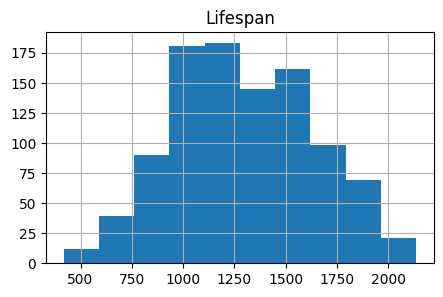

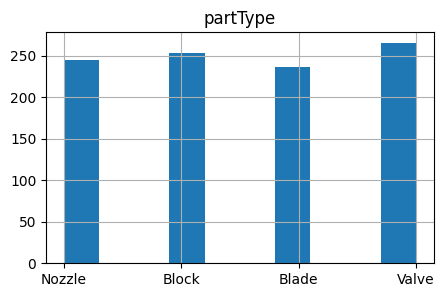

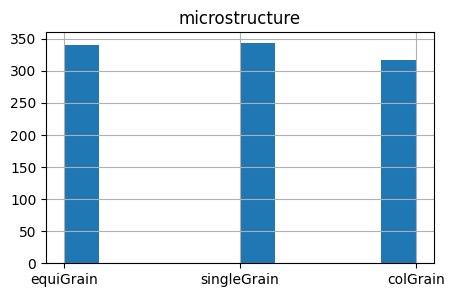

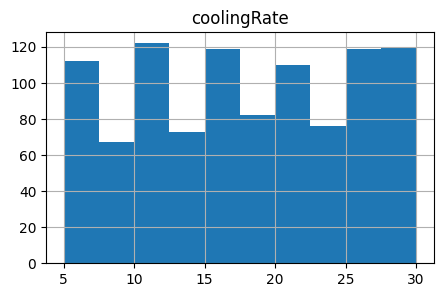

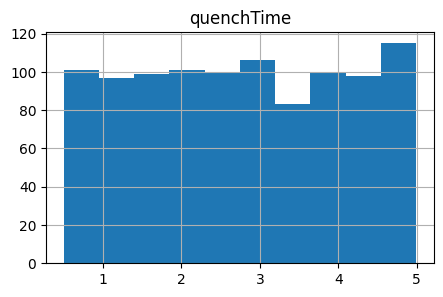

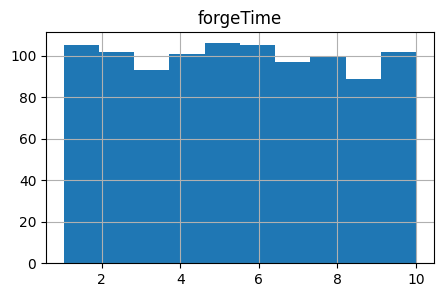

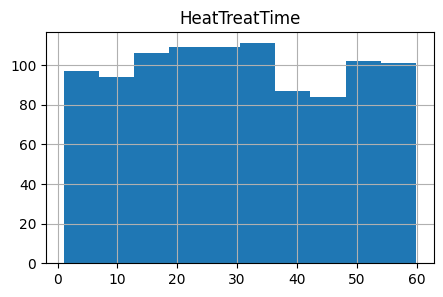

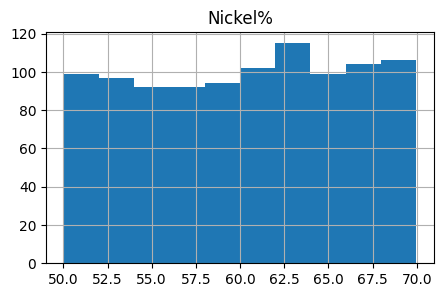

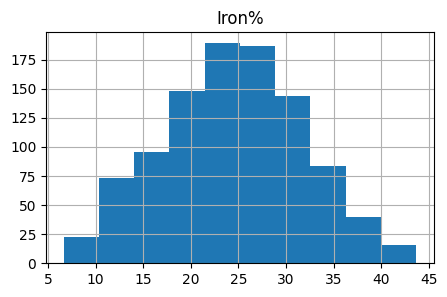

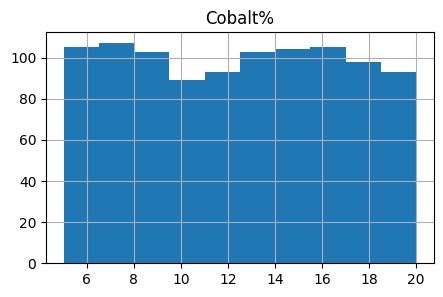

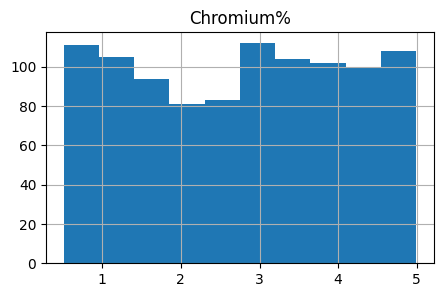

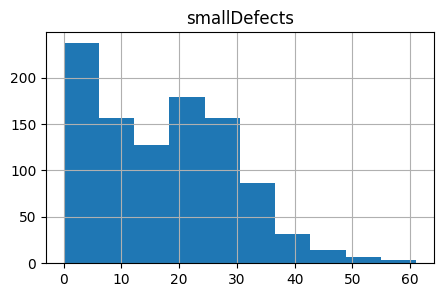

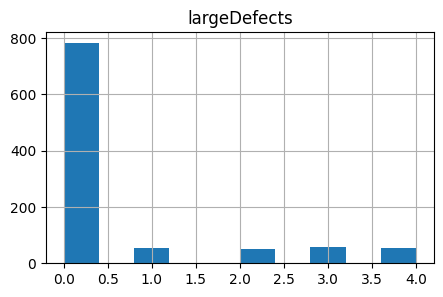

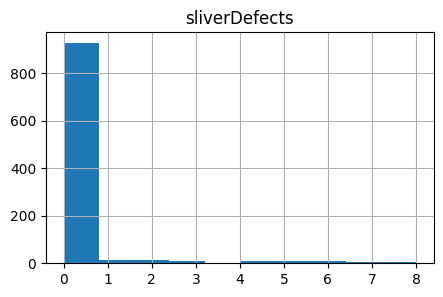

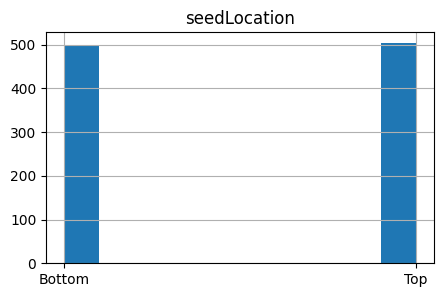

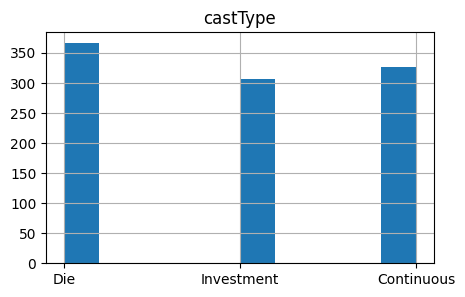

In [4]:
metalData_df = pd.DataFrame(metalData_csv)
for i in metalData_df.columns:
  plt.figure(figsize=(5,3))
  plt.title(i)
  metalData_df[i].hist()

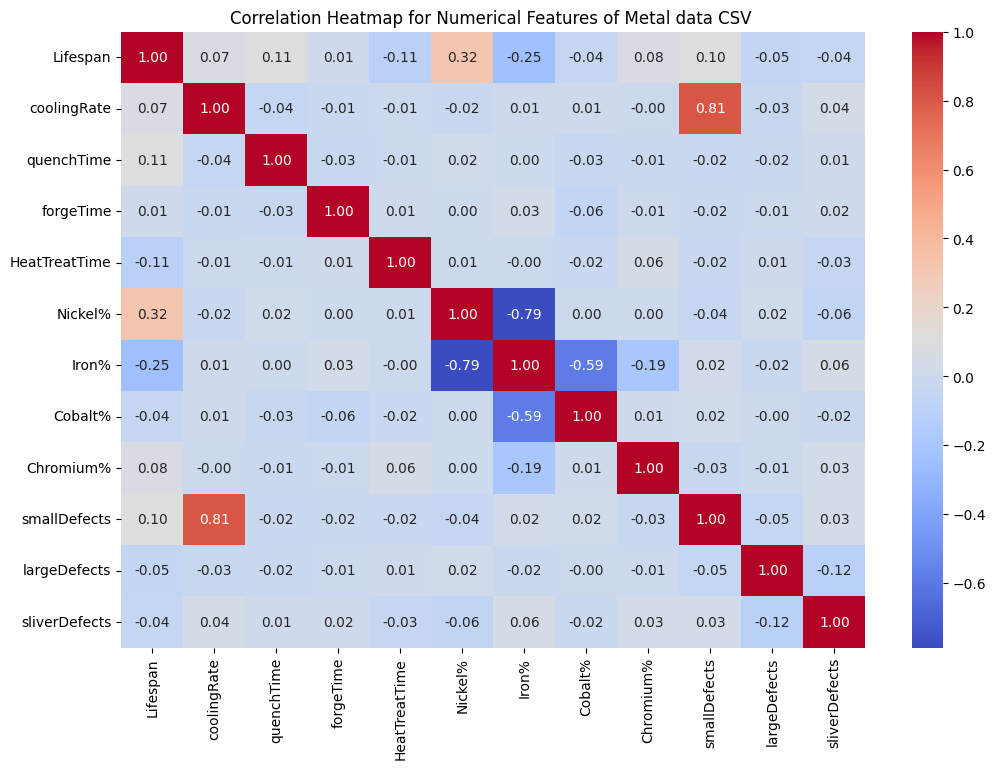

In [5]:
categorical_cols = ['partType','microstructure','seedLocation','castType']

correlation_matrix = metalData_csv.drop(categorical_cols, axis=1).corr() # dropping categorical features from csv
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Numerical Features of Metal data CSV ')
plt.show()

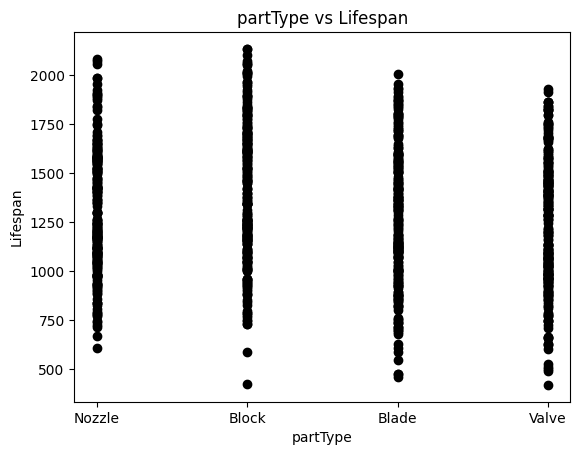

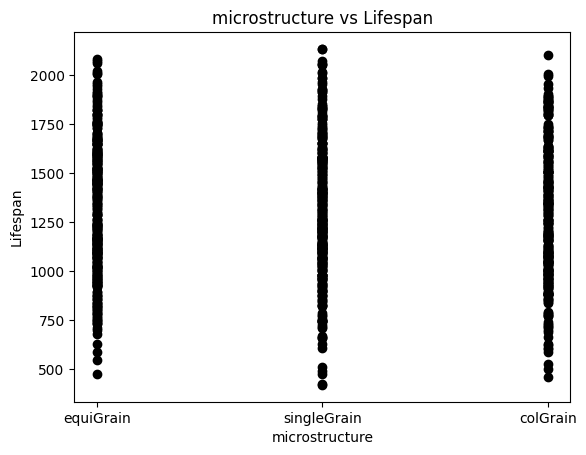

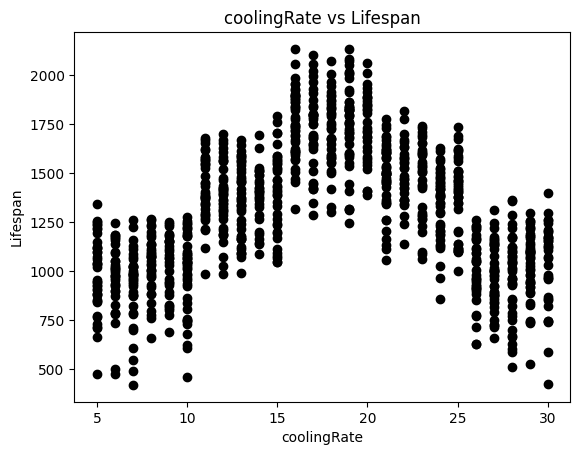

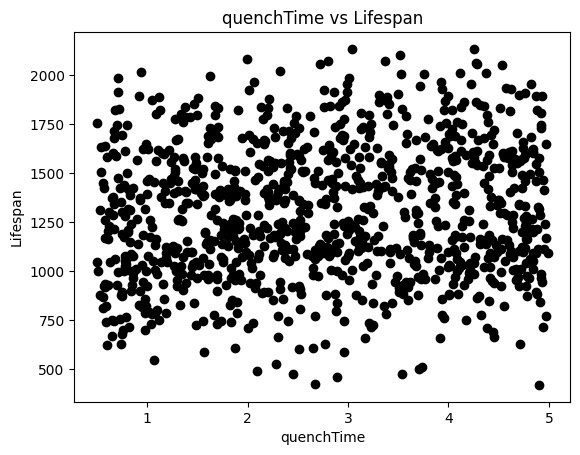

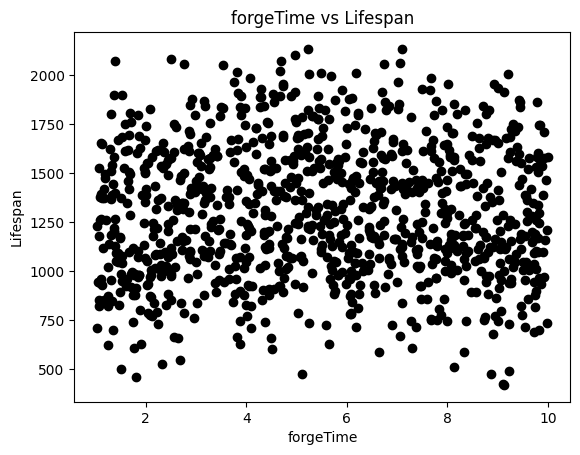

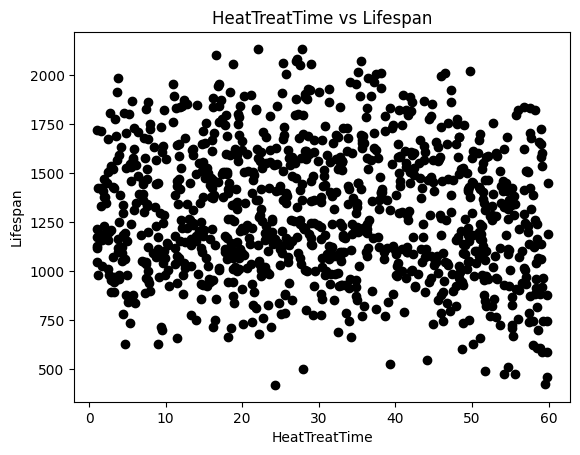

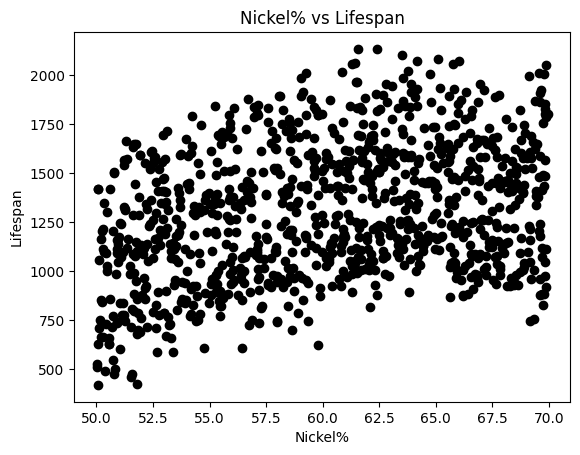

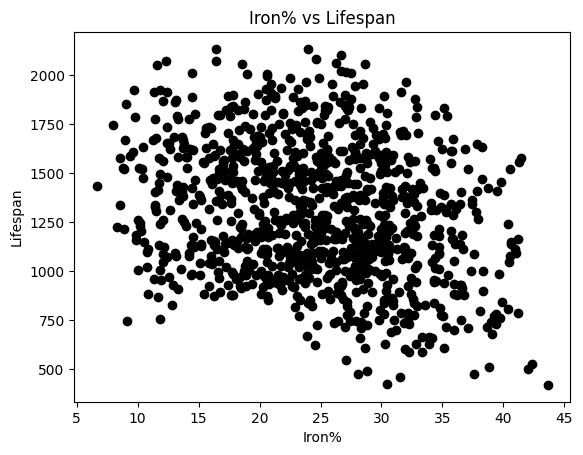

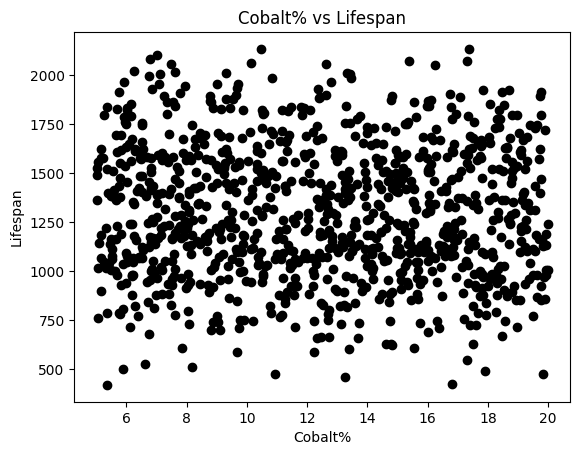

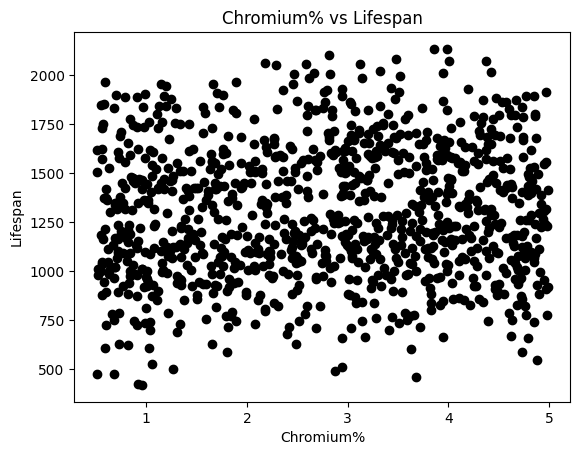

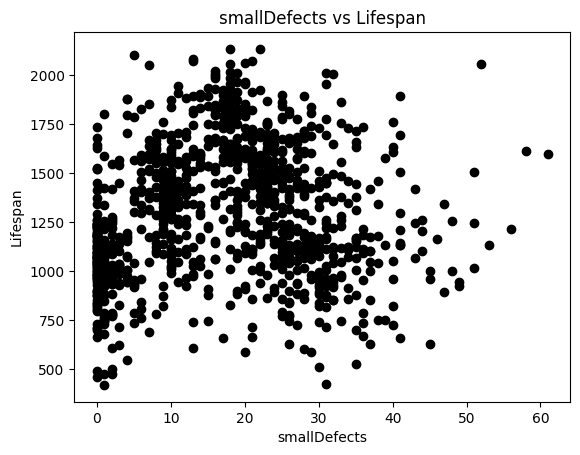

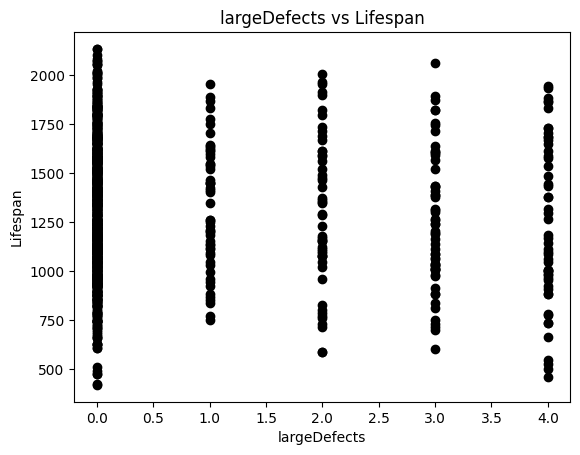

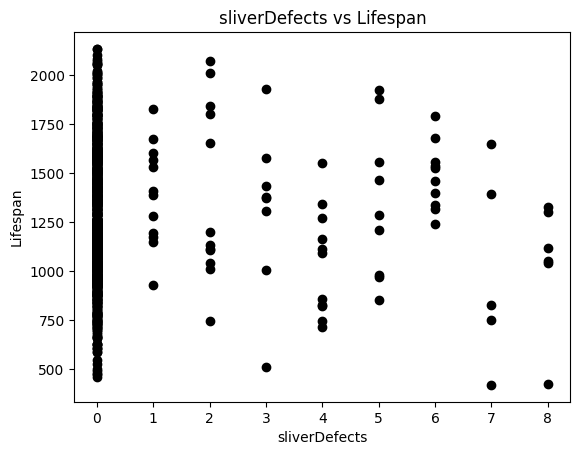

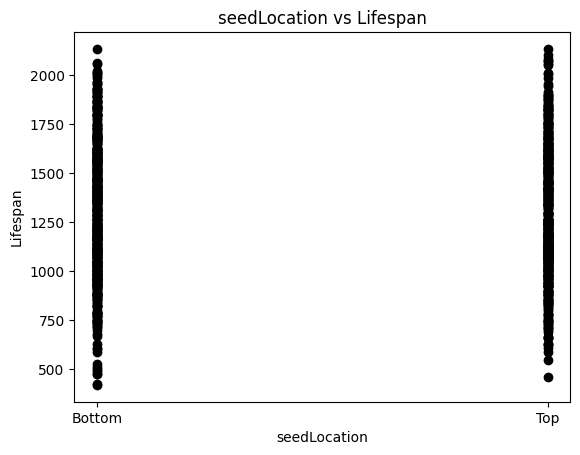

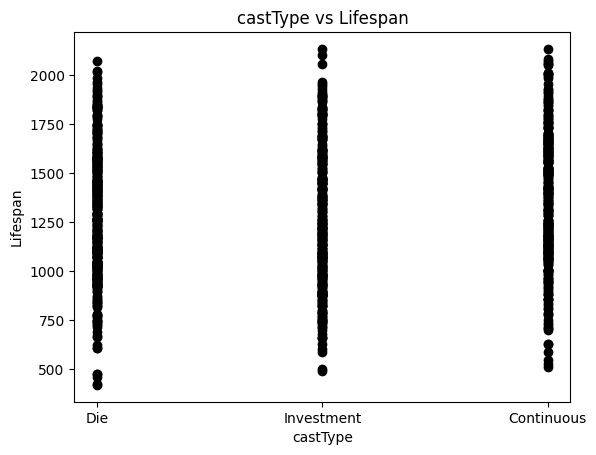

In [6]:
for i in metalData_csv.columns:
    if i == 'Lifespan':
        continue
    else:
        plt.title(i + ' vs Lifespan')
        X = metalData_csv[i]
        y = metalData_csv['Lifespan']
        plt.scatter(X, y,  color='black', label='y') # Observed y values
        plt.xlabel(i)
        plt.ylabel('Lifespan')
        plt.show()

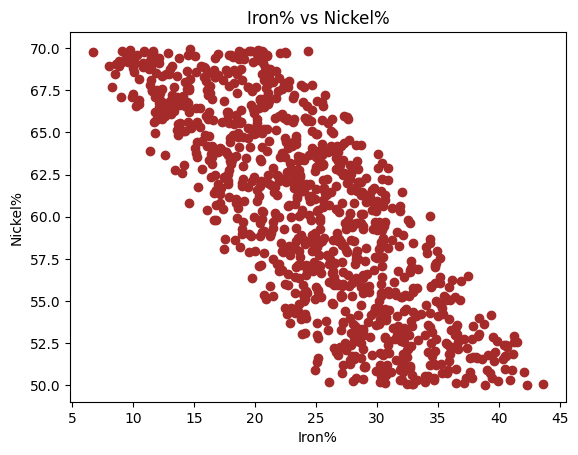

In [7]:
plt.title('Iron% vs Nickel%')
X = metalData_csv['Iron%']
y = metalData_csv['Nickel%']
plt.scatter(X, y,  color='brown', label='y') # Observed y values
plt.xlabel('Iron%')
plt.ylabel('Nickel%')
plt.show()

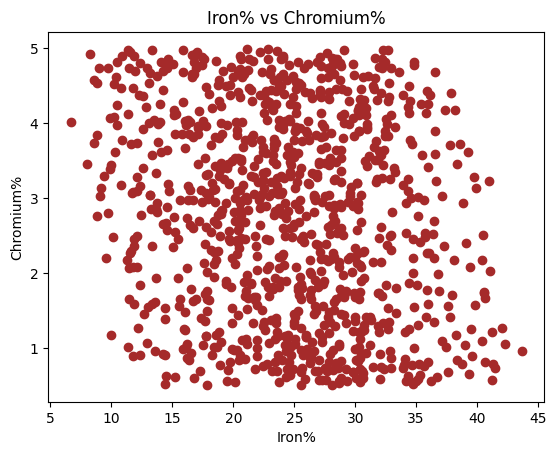

In [8]:
plt.title('Iron% vs Chromium%')
X = metalData_csv['Iron%']
y = metalData_csv['Chromium%']
plt.scatter(X, y,  color='brown', label='y') # Observed y values
plt.xlabel('Iron%')
plt.ylabel('Chromium%')
plt.show()

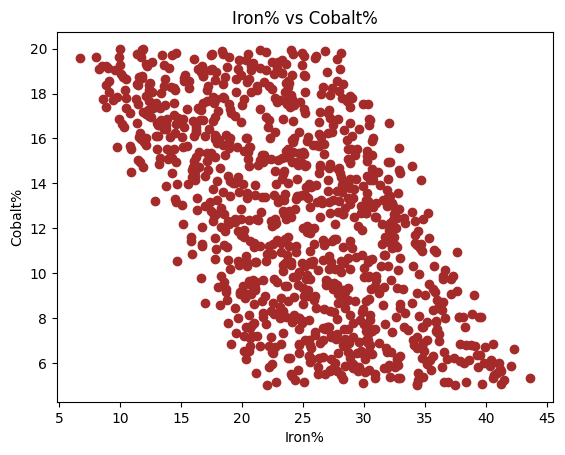

In [9]:
plt.title('Iron% vs Cobalt%')
X = metalData_csv['Iron%']
y = metalData_csv['Cobalt%']
plt.scatter(X, y,  color='brown', label='y') # Observed y values
plt.xlabel('Iron%')
plt.ylabel('Cobalt%')
plt.show()

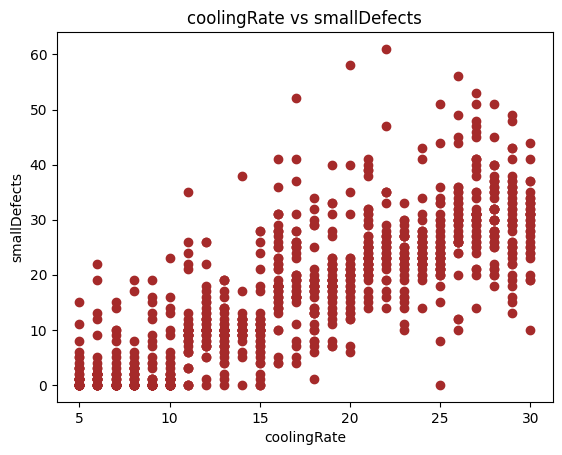

In [10]:
plt.title('coolingRate vs smallDefects')
X = metalData_csv['coolingRate']
y = metalData_csv['smallDefects']
plt.scatter(X, y,  color='brown', label='y') # Observed y values
plt.xlabel('coolingRate')
plt.ylabel('smallDefects')
plt.show()

4.   Data Preprocessing

In [11]:
metalData_OHencoded = metalData_csv.copy()
# creating OneHotEncoder object
oneHotEncoder = OneHotEncoder()
# fitting the OneHotEncoder object to feature partType
onehot_enc = oneHotEncoder.fit(metalData_OHencoded[['partType']])
print('The categories are: ', onehot_enc.categories_)
# making a temporary object to be able to manipulate the extra number of columns
OHT = onehot_enc.transform(metalData_OHencoded[['partType']]).toarray()

# adding the encoded columns to our dataset
metalData_OHencoded[np.unique(metalData_csv['partType'])[0]] = OHT[:,0]
metalData_OHencoded[np.unique(metalData_csv['partType'])[1]] = OHT[:,1]
metalData_OHencoded[np.unique(metalData_csv['partType'])[2]] = OHT[:,2]
metalData_OHencoded[np.unique(metalData_csv['partType'])[3]] = OHT[:,3]

# chacking that the new columns correspond to the correct part types
display(metalData_OHencoded)

The categories are:  [array(['Blade', 'Block', 'Nozzle', 'Valve'], dtype=object)]


,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects,seedLocation,castType,Blade,Block,Nozzle,Valve
0,1469.17,Nozzle,equiGrain,13,3.84,6.47,46.87,65.73,16.52,16.82,0.93,10,0,0,Bottom,Die,0.0,0.0,1.0,0.0
1,1793.64,Block,singleGrain,19,2.62,3.48,44.70,54.22,35.38,6.14,4.26,19,0,0,Bottom,Investment,0.0,1.0,0.0,0.0
2,700.60,Blade,equiGrain,28,0.76,1.34,9.54,51.83,35.95,8.81,3.41,35,3,0,Bottom,Investment,1.0,0.0,0.0,0.0
3,1082.10,Nozzle,colGrain,9,2.01,2.19,20.29,57.03,23.33,16.86,2.78,0,1,0,Top,Continuous,0.0,0.0,1.0,0.0
4,1838.83,Blade,colGrain,16,4.13,3.87,16.13,59.62,27.37,11.45,1.56,10,0,0,Top,Die,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1217.50,Block,singleGrain,5,1.91,8.55,34.76,68.11,20.73,7.15,4.01,0,0,0,Bottom,Investment,0.0,1.0,0.0,0.0
996,742.05,Block,singleGrain,10,0.67,7.99,46.21,51.25,32.12,12.23,4.40,1,0,0,Bottom,Investment,0.0,1.0,0.0,0.0
997,1448.26,Nozzle,equiGrain,17,3.12,7.61,59.87,54.09,33.20,9.31,3.40,16,1,0,Bottom,Investment,0.0,0.0,1.0,0.0
998,1099.10,Valve,colGrain,23,4.48,2.39,17.72,50.32,31.92,13.01,4.75,11,0,0,Top,Continuous,0.0,0.0,0.0,1.0


In [12]:
# creating a list of selected features for dataset
selectedFeatures = ['Lifespan','Blade','Block','Nozzle','Valve','HeatTreatTime','Nickel%','Iron%','coolingRate']
metalData_encoded = metalData_OHencoded[selectedFeatures]
# viewing the dataset having only selected features
display(metalData_encoded)

,Lifespan,Blade,Block,Nozzle,Valve,HeatTreatTime,Nickel%,Iron%,coolingRate
0,1469.17,0.0,0.0,1.0,0.0,46.87,65.73,16.52,13
1,1793.64,0.0,1.0,0.0,0.0,44.70,54.22,35.38,19
2,700.60,1.0,0.0,0.0,0.0,9.54,51.83,35.95,28
3,1082.10,0.0,0.0,1.0,0.0,20.29,57.03,23.33,9
4,1838.83,1.0,0.0,0.0,0.0,16.13,59.62,27.37,16
...,...,...,...,...,...,...,...,...,...
995,1217.50,0.0,1.0,0.0,0.0,34.76,68.11,20.73,5
996,742.05,0.0,1.0,0.0,0.0,46.21,51.25,32.12,10
997,1448.26,0.0,0.0,1.0,0.0,59.87,54.09,33.20,17
998,1099.10,0.0,0.0,0.0,1.0,17.72,50.32,31.92,23


In [13]:
# creating feature matrix X containing all features except Lifespan, the target
X = np.array(metalData_encoded.drop(['Lifespan'],axis=1))
# creating the target variable y containing the target Lifespan
y = np.array(metalData_encoded['Lifespan'])

In [14]:
# Split the non-test data into non-test/test data
# We use 25% of the remaining non-test data only for the validation set, leaving the rest for training
# In the end, the splitting ratio will be 6:2:2 for the training, validation, and test data.
# `shuffle=True` for non-time series case. You should set `shuffle=False` for time series data to avoid future data being contaminated in the training data.
X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=0.25, shuffle=True, random_state=0)

## Part 3 Regression Implementation

### 3.1 Methodology and Hyperparameter Tuning Framework for Ridge Regression

In [15]:
max_degree = 5 #Define the max degree to test
# Initialise the MSE arrays, filling them with NaN's
mse_train_array = np.full([max_degree + 1], np.nan)
mse_valid_array = np.full([max_degree + 1], np.nan)
degrees = range(1, max_degree+1) # create list of degree values being iterated through

for degree in degrees:
    # Initialise
    model = sklearn.linear_model.LinearRegression()
    poly = PolynomialFeatures(degree=degree)
    scaler = MinMaxScaler()

    # Train
    poly.fit(X_train_raw)
    X_train_poly = poly.transform(X_train_raw)
    scaler.fit(X_train_poly)
    X_train = scaler.transform(X_train_poly)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)

    # Validate
    X_valid_poly = poly.transform(X_valid_raw)
    X_valid = scaler.transform(X_valid_poly)
    y_pred_valid = model.predict(X_valid)
    mse_valid = mean_squared_error(y_valid, y_pred_valid)

    # Store MSE for this degree value
    mse_train_array[degree] = mse_train
    mse_valid_array[degree] = mse_valid

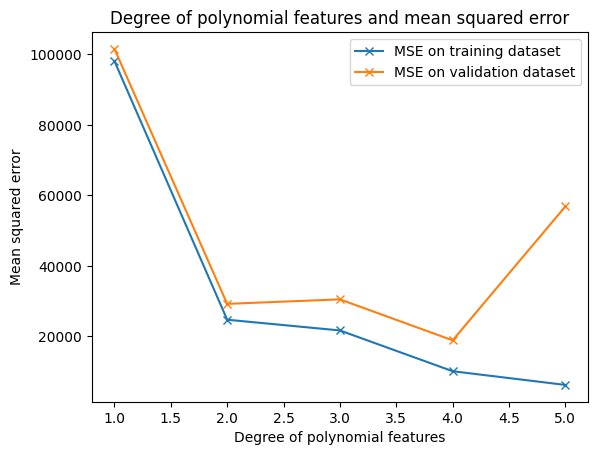

The best degree of polynomials: 4
Validation MSE at best degree: 18858.411400250003


In [16]:
plt.plot(degrees, mse_train_array[1:], '-x', label='MSE on training dataset')
plt.plot(degrees, mse_valid_array[1:], '-x', label='MSE on validation dataset')
plt.xlabel('Degree of polynomial features')
plt.ylabel('Mean squared error')
plt.title('Degree of polynomial features and mean squared error')
plt.legend()
plt.show()

best_degree = np.nanargmin(mse_valid_array) # Finds the smallest VALIDATION MSE in the array (ignoring any NaN values).
print('The best degree of polynomials:', best_degree)
print('Validation MSE at best degree:', mse_valid_array[np.nanargmin(mse_valid_array)])

In [17]:
model = sklearn.linear_model.LinearRegression()
poly = PolynomialFeatures(degree=best_degree)
scaler = MinMaxScaler()

# Test
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)
model.fit(X_train, y_train)

X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)
y_pred_test = model.predict(X_test)

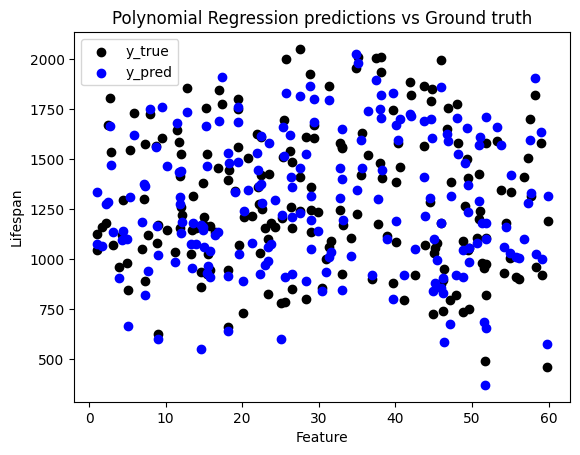

MSE on the test data:  20255.56018525
R2 score on the test data:  0.831192613790576


In [18]:
plt.scatter(X_test_raw[:,4], y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,4], y_pred_test, color='blue', label='y_pred') # predicted y values
plt.xlabel('Feature')
plt.ylabel('Lifespan')
plt.title('Polynomial Regression predictions vs Ground truth')
plt.legend()
plt.show()

mse_test = mean_squared_error(y_test, y_pred_test) # calculate the MSE
print('MSE on the test data: ', mse_test)
R2 = r2_score(y_test, y_pred_test) # calculate the MSE
print('R2 score on the test data: ',R2)

alpha: 1e-10, Validation mean squared error: 17860.7756092413.
alpha: 1e-09, Validation mean squared error: 17832.61840401696.
alpha: 1e-08, Validation mean squared error: 17819.041205200763.
alpha: 1e-07, Validation mean squared error: 17784.314986778038.
alpha: 1e-06, Validation mean squared error: 17460.96198470506.
alpha: 1e-05, Validation mean squared error: 16875.49228464804.
alpha: 0.0001, Validation mean squared error: 17351.624923480107.
alpha: 0.001, Validation mean squared error: 21677.773153344617.
alpha: 0.01, Validation mean squared error: 27672.04306194733.
alpha: 0.1, Validation mean squared error: 29008.46103145066.
alpha: 1.0, Validation mean squared error: 30794.8656628556.
alpha: 10.0, Validation mean squared error: 43019.439155714696.
alpha: 100.0, Validation mean squared error: 84288.90466729752.
alpha: 1000.0, Validation mean squared error: 103686.96748818632.
alpha: 10000.0, Validation mean squared error: 112251.07245958349.
alpha: 100000.0, Validation mean squa

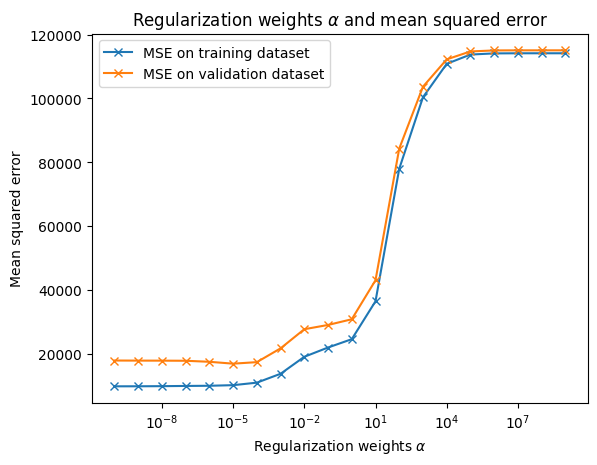

The best alpha: 1e-05
Validation MSE at best alpha:  16875.49228464804


In [19]:
###################################
# Initialise Model and preprocessors
###################################
degree = best_degree # Choose your degree. Regularisation will eliminate any values that hurt our model, but do beware about going to big, or python may not be able to cope with the number of features.
alpha_indices = np.arange(20) # Get a list of 1-20
alphas = 10.0 ** (alpha_indices -10) # Define a list of alphas by taking indices from 10 to -10
# Get the MSE arrays
mse_train_array = np.full([len(alphas)], np.nan)
mse_valid_array = np.full([len(alphas)], np.nan)

poly = PolynomialFeatures(degree=degree)
scaler = MinMaxScaler()

#######################
# Training & validation
#######################

# preprocessing
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)
#X_train_pca = pca.fit_transform(X_train)

X_valid_poly = poly.transform(X_valid_raw)
X_valid = scaler.transform(X_valid_poly)
#X_valid_pca = pca.fit_transform(X_valid)
# Loop to test alpha values
for alpha_index, alpha in zip(alpha_indices, alphas):
  # train
    model = Ridge(alpha=alpha) # fits our ridge model with a new regularisation weight each iteration
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)

    # Validation
    y_pred_valid = model.predict(X_valid)
    mse_valid = mean_squared_error(y_valid, y_pred_valid)

    # Store MSEs for this iteration
    mse_train_array[alpha_index] = mse_train
    mse_valid_array[alpha_index] = mse_valid
    print(f'alpha: {alpha}, Validation mean squared error: {mse_valid}.')

# Plot our graph of MSE for training and validation
plt.plot(alphas, mse_train_array, '-x', label='MSE on training dataset')
plt.plot(alphas, mse_valid_array, '-x', label='MSE on validation dataset')
plt.xlabel(r'Regularization weights $\alpha$')
plt.ylabel('Mean squared error')
plt.title(r'Regularization weights $\alpha$ and mean squared error')
plt.xscale('log')
plt.legend()
plt.show()

# Select our best performing alpha (lowest MSE)
best_alpha_index = np.argmin(mse_valid_array)
best_alpha = alphas[best_alpha_index]
print('The best alpha:', best_alpha)
print('Validation MSE at best alpha: ',mse_valid_array[np.nanargmin(mse_valid_array)])

### 3.2 Evaluation for Ridge Regression

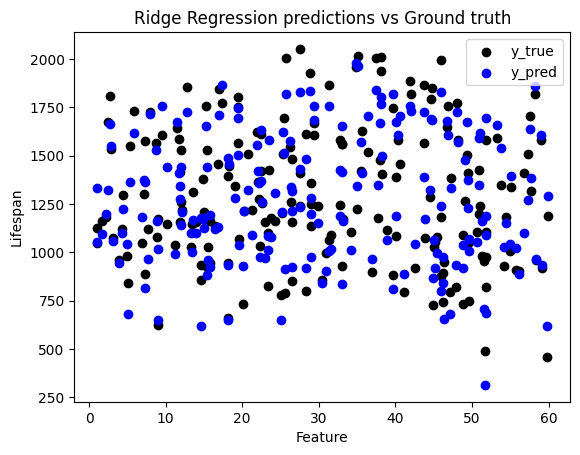

MSE on the test data: 18600.396365446333
R2 score on test data: 0.8449865486713759


In [20]:
######
# Test
######

#refit our model with the best alpha
model = Ridge(alpha=best_alpha) # fits our ridge model with a new regularisation weight each iteration
model.fit(X_train, y_train)

# Preprocess test data
X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)

# Predict test data
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
R2 = r2_score(y_test, y_pred_test)

# Plot outputs
plt.scatter(X_test_raw[:,4], y_test, color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,4], y_pred_test, color='blue', label='y_pred') # predicted y values
plt.xlabel('Feature')
plt.ylabel('Lifespan')
plt.title(r'Ridge Regression predictions vs Ground truth')
plt.legend()
plt.show()

# calculate the MSE
print('MSE on the test data:', mse_test)
# The R2 score: 1 is perfect prediction
print('R2 score on test data:', R2)

### 3.1 Methodology and Hyperparameter tuning for Decision Tree Regressor

In [21]:
# Hyperparameter grid for GridSearchCV
param_grid = {
    'poly__degree': [1,2,4],  # Values for PolynomialFeatures degree
    'tree__max_depth': [2,4,8],  # Values for DecisionTreeRegressor max depth
    'tree__min_samples_split': [5,10,15]  # Values for DecisionTreeRegressor min_samples_split
    #'tree__min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]
}

# Initialize Model and preprocessors
tree = DecisionTreeRegressor()
poly = PolynomialFeatures()  # Apply PolynomialFeatures only to the selected feature
scaler = MinMaxScaler()

# Create a pipeline with preprocessing and Decision Tree regression
pipeline = Pipeline([
    ('poly', poly),
    ('scaler', scaler),
    ('tree', tree)
])


x=X.tolist()
xtrain=X_train_raw.tolist()
indices=[]
for item in x:
  if item in xtrain:
    indices.append(-1)
  else:
    indices.append(0)

# using predefined split to use our validation data
split = PredefinedSplit(test_fold = indices)

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=split, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model with GridSearchCV
grid_search.fit(X, y)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_
# Print the best model
print("Best Model:", best_model)

best_model.fit(X_train_raw, y_train)

#Train
y_pred_train = best_model.predict(X_train_raw)
mse_train = mean_squared_error(y_train, y_pred_train)
# MSE on train data
print('MSE on the training data:', mse_train)

#Validate
y_pred_valid = best_model.predict(X_valid_raw)
mse_valid = mean_squared_error(y_valid, y_pred_valid)
# MSE on valid data
print('MSE on the validation data:', mse_valid)

Best Hyperparameters: {'poly__degree': 2, 'tree__max_depth': 8, 'tree__min_samples_split': 15}
Best Model: Pipeline(steps=[('poly', PolynomialFeatures()), ('scaler', MinMaxScaler()),
                ('tree',
                 DecisionTreeRegressor(max_depth=8, min_samples_split=15))])
MSE on the training data: 4713.298476528278
MSE on the validation data: 10496.724094124962


In [22]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,param_tree__max_depth,param_tree__min_samples_split,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012061,0.0,0.002015,0.0,1,2,5,"{'poly__degree': 1, 'tree__max_depth': 2, 'tre...",-47432.411139,-47432.411139,0.0,24
1,0.011398,0.0,0.001973,0.0,1,2,10,"{'poly__degree': 1, 'tree__max_depth': 2, 'tre...",-47432.411139,-47432.411139,0.0,24
2,0.003888,0.0,0.001541,0.0,1,2,15,"{'poly__degree': 1, 'tree__max_depth': 2, 'tre...",-47432.411139,-47432.411139,0.0,24
3,0.004591,0.0,0.001899,0.0,1,4,5,"{'poly__degree': 1, 'tree__max_depth': 4, 'tre...",-28228.319828,-28228.319828,0.0,11
4,0.004364,0.0,0.001502,0.0,1,4,10,"{'poly__degree': 1, 'tree__max_depth': 4, 'tre...",-28263.567803,-28263.567803,0.0,12
5,0.004441,0.0,0.001539,0.0,1,4,15,"{'poly__degree': 1, 'tree__max_depth': 4, 'tre...",-28263.567803,-28263.567803,0.0,13
6,0.005739,0.0,0.001614,0.0,1,8,5,"{'poly__degree': 1, 'tree__max_depth': 8, 'tre...",-11242.395215,-11242.395215,0.0,6
7,0.006383,0.0,0.001696,0.0,1,8,10,"{'poly__degree': 1, 'tree__max_depth': 8, 'tre...",-10968.221422,-10968.221422,0.0,3
8,0.005191,0.0,0.001598,0.0,1,8,15,"{'poly__degree': 1, 'tree__max_depth': 8, 'tre...",-11031.858185,-11031.858185,0.0,4
9,0.008250,0.0,0.002181,0.0,2,2,5,"{'poly__degree': 2, 'tree__max_depth': 2, 'tre...",-47432.411139,-47432.411139,0.0,22


Text(0.5, 1.0, 'Grid Search CV for Decision Tree Regressor')

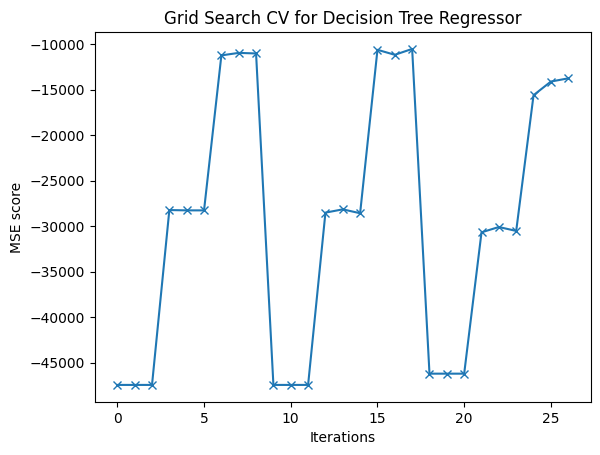

In [23]:
plt.plot(grid_search.cv_results_['mean_test_score'], '-x', label='MSE on validation dataset')
plt.xlabel(r'Iterations')
plt.ylabel('MSE score')
plt.title('Grid Search CV for Decision Tree Regressor')

### 3.2 Evaluation for Decision Tree Regressor

In [24]:
# Predict test data
y_pred_test = best_model.predict(X_test_raw)
mse_test = mean_squared_error(y_test, y_pred_test)
R2 = r2_score(y_test, y_pred_test)

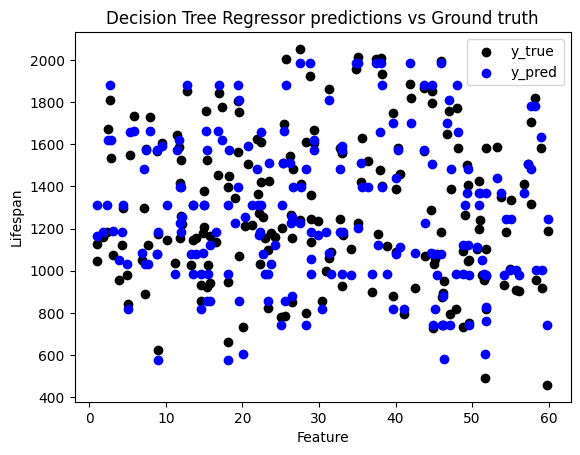

MSE on the test data: 11293.107148879633
R2 score on test data: 0.9058846122965518


In [25]:
# Plot outputs
plt.scatter(X_test_raw[:, 4], y_test,  color='black', label='y_true')  # Observed y values
plt.scatter(X_test_raw[:, 4], y_pred_test, color='blue', label='y_pred')  # Predicted y values
plt.xlabel('Feature')
plt.ylabel('Lifespan')
plt.title(r'Decision Tree Regressor predictions vs Ground truth')
plt.legend()
plt.show()

# MSE on test data
print('MSE on the test data:', mse_test)
# The R2 score: 1 is perfect prediction
print('R2 score on test data:',R2)

## Part 4 Classification

### 4.1 Feature Crafting

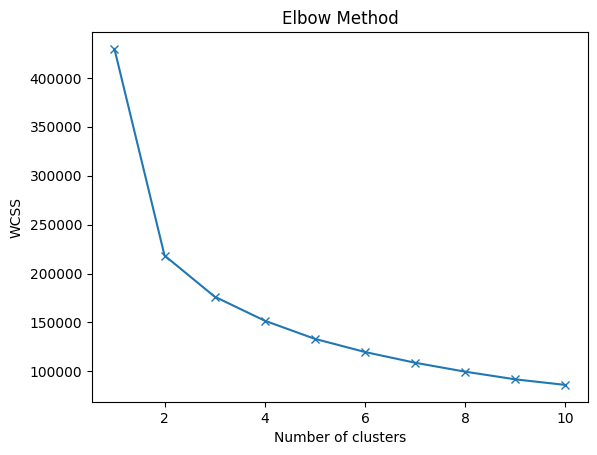

In [26]:
# Using the elbow method to find a good number of clusters using WCSS (within-cluster sums of squares)
wcss = []

# Let's check for up to 10 clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    x_pred_kmeans = X
    kmeans.fit(x_pred_kmeans)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, '-x')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

According to elbow method, the best number of clusters k is 2 or 3 as shown in figure above. As we are performing multiclass classification, we will select the vlaue of k as 3.

In [27]:
# statistics about Lifespan in the dataset
metalData_csv['Lifespan'].describe()

,Lifespan
count,1000.000000
mean,1298.556320
std,340.071434
min,417.990000
25%,1047.257500
50%,1266.040000
75%,1563.050000
max,2134.530000


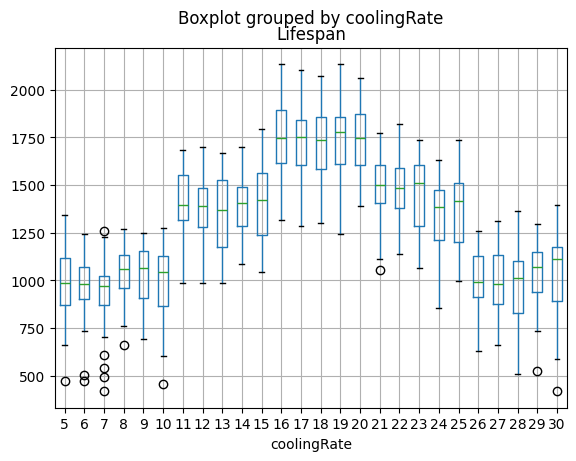

In [28]:
#Statistical outlier function to form the Lifespan classes

boxplot = metalData_csv.boxplot(column=['Lifespan'], by='coolingRate', grid = True, return_type='dict')
plt.show()

In [29]:
# Collecting the values of all outliers, medians, whiskers and boxes (quartiles) from the bosxplot
whiskers=[]
mdeians = []
boxes =[]
outliers= []
for item in boxplot:
  whiskers = [whiskers.get_ydata() for whiskers in item["whiskers"]]
  medians = [median.get_ydata() for median in item["medians"]]
  boxes = [box.get_ydata() for box in item["boxes"]]
  outliers = [flier.get_ydata() for flier in item["fliers"]]

In [30]:
print("Outliers: ", outliers)
print("Boxes: ", boxes)
print("Medians: ", medians)
print("Whiskers: ", whiskers)

Outliers:  [array([474.54], dtype=object), array([501.5, 471.71], dtype=object), array([543.0, 608.67, 490.78, 417.99, 1258.89], dtype=object), array([659.15], dtype=object), array([], dtype=object), array([457.96], dtype=object), array([], dtype=object), array([], dtype=object), array([], dtype=object), array([], dtype=object), array([], dtype=object), array([], dtype=object), array([], dtype=object), array([], dtype=object), array([], dtype=object), array([], dtype=object), array([1053.76], dtype=object), array([], dtype=object), array([], dtype=object), array([], dtype=object), array([], dtype=object), array([], dtype=object), array([], dtype=object), array([], dtype=object), array([522.65], dtype=object), array([422.03], dtype=object)]
Boxes:  [array([ 870.1525,  870.1525, 1118.4675, 1118.4675,  870.1525]), array([ 900.025,  900.025, 1071.04 , 1071.04 ,  900.025]), array([ 869.77,  869.77, 1025.2 , 1025.2 ,  869.77]), array([ 961.29  ,  961.29  , 1133.7125, 1133.7125,  961.29  ]), 

In [31]:
classinterval0=[]
classinterval1=[]
classinterval2=[]
for i in range(len(whiskers)):
  for j in range(len(whiskers[i])):
    if (0<=i<=11 or 42<=i<=51)  and i%2!=0:
      if j==1:
        classinterval0.append(whiskers[i][j])
      else:
        continue
    elif (12<=i<=21 or 32<=i<=41) and i%2!=0:
      if j==1:
        classinterval1.append(whiskers[i][j])
      else:
        continue
    elif 22<=i<=31 and i%2!=0:
      if j==1:
        classinterval2.append(whiskers[i][j])
      else:
        continue

In [32]:
upperboundforClass0=np.mean(np.array(classinterval0))
upperboundforClass1=np.mean(np.array(classinterval1))
upperboundforClass2=np.mean(np.array(classinterval2))

min_lifespan = metalData_csv['Lifespan'].describe()['min']
max_lifespan = metalData_csv['Lifespan'].describe()['max']

print('Class 0 interval: ', min_lifespan, 'to ', upperboundforClass0)
print('Class 1 interval: ', upperboundforClass0, 'to ', upperboundforClass1)
print('Class 2 interval: ', upperboundforClass1, 'to ', max_lifespan)

Class 0 interval:  417.99 to  1293.7390909090907
Class 1 interval:  1293.7390909090907 to  1723.575
Class 2 interval:  1723.575 to  2134.53


In [33]:
#### for 3 class classification
SEED=0

y_categorical = [] #0-1250, 1250-1650, 1650-max

for i in range(len(y)):
    if 0<y[i]<=upperboundforClass0:
        y_categorical.append(0) # Below 1293
    elif upperboundforClass0<y[i]<=upperboundforClass1:
        y_categorical.append(1) # Between 1293 and 1724
    elif upperboundforClass1<y[i]<=max_lifespan:
        y_categorical.append(2) # Above 1724

y_categorical = np.array(y_categorical)

In [34]:
X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X, y_categorical, test_size=0.20, shuffle=True, random_state=SEED)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=0.25, shuffle=True, random_state=SEED)

In [35]:
scaler = MinMaxScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_valid = scaler.transform(X_valid_raw)
X_test = scaler.transform(X_test_raw)

### 4.2 Hyperparameter Tuning for Gradient Boosting Classifier

In [36]:
# Setting SEED for reproducibility
SEED = 0
random.seed(SEED)

param_grid = {
    'n_estimators': [50,100,200,300],
    'learning_rate': [0.001,0.01,0.1,1],
    'max_depth': [1,2,3,4,5,6,7,8,9,10]
}


x=X.tolist()
xtrain=X_train_raw.tolist()
indices=[]
for item in x:
  if item in xtrain:
    indices.append(-1)
  else:
    indices.append(0)

# using predefined split to use our validation data
split = PredefinedSplit(test_fold = indices)

# Initialize the Gradient Boosting model
model = GradientBoostingClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=split, scoring='accuracy', n_jobs=-1, verbose=3)

# Fit the model to the training data using GridSearchCV
grid_search.fit(X, y_categorical)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the results
print('Best Parameters:, ',best_params)

#Train
y_pred_train = best_model.predict(X_train_raw)
acc_train = accuracy_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train, average='weighted', pos_label=1)
# MSE on train data
print('Accuracy on the training data:', acc_train)

#Validate
y_pred_valid = best_model.predict(X_valid_raw)
acc_valid = accuracy_score(y_valid, y_pred_valid)
f1_vaid = f1_score(y_valid, y_pred_valid, average='weighted', pos_label=1)
# MSE on valid data
print('Accuracy on the validation data:', acc_valid)

Fitting 1 folds for each of 160 candidates, totalling 160 fits
Best Parameters:,  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}
Accuracy on the training data: 1.0
Accuracy on the validation data: 1.0


In [37]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.329176,0.0,0.003489,0.0,0.001,1,50,"{'learning_rate': 0.001, 'max_depth': 1, 'n_es...",0.5350,0.5350,0.0,146
1,0.494328,0.0,0.004113,0.0,0.001,1,100,"{'learning_rate': 0.001, 'max_depth': 1, 'n_es...",0.5350,0.5350,0.0,146
2,0.998355,0.0,0.005114,0.0,0.001,1,200,"{'learning_rate': 0.001, 'max_depth': 1, 'n_es...",0.5350,0.5350,0.0,146
3,1.453356,0.0,0.006265,0.0,0.001,1,300,"{'learning_rate': 0.001, 'max_depth': 1, 'n_es...",0.5350,0.5350,0.0,146
4,0.354085,0.0,0.005746,0.0,0.001,2,50,"{'learning_rate': 0.001, 'max_depth': 2, 'n_es...",0.5350,0.5350,0.0,146
...,...,...,...,...,...,...,...,...,...,...,...,...
155,1.581122,0.0,0.006368,0.0,1.000,9,300,"{'learning_rate': 1, 'max_depth': 9, 'n_estima...",0.8925,0.8925,0.0,54
156,0.761695,0.0,0.004502,0.0,1.000,10,50,"{'learning_rate': 1, 'max_depth': 10, 'n_estim...",0.9000,0.9000,0.0,22
157,0.898936,0.0,0.005017,0.0,1.000,10,100,"{'learning_rate': 1, 'max_depth': 10, 'n_estim...",0.8925,0.8925,0.0,54
158,1.218685,0.0,0.005757,0.0,1.000,10,200,"{'learning_rate': 1, 'max_depth': 10, 'n_estim...",0.8900,0.8900,0.0,72


Text(0.5, 1.0, 'Grid Search CV for Gradient Boost Classifier')

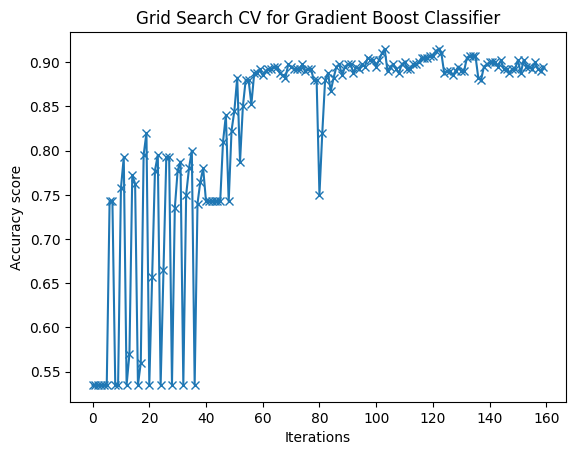

In [38]:
plt.plot(grid_search.cv_results_['mean_test_score'], '-x', label='Accuracy on validation dataset')
plt.xlabel(r'Iterations')
plt.ylabel('Accuracy score')
plt.title('Grid Search CV for Gradient Boost Classifier')

### 4.3 Evaluation for Gradient Boost Classifier

In [39]:
# Make predictions on the test set using the best model
y_pred_test = best_model.predict(X_test_raw)

The accuracy on the test data with the selected hyperparameter: 1.0
The F1 score on the test data with the selected hyperparameter: 1.0
Precision on test data: 1.0
Recall on test data: 1.0


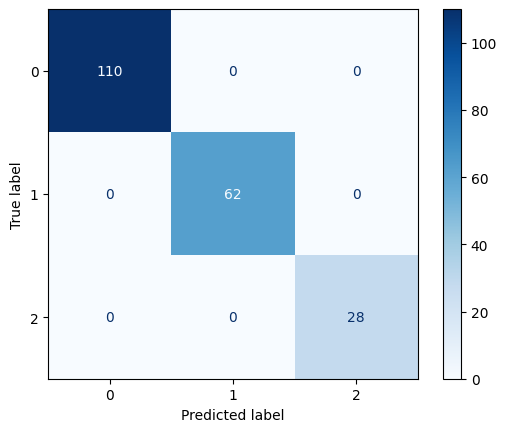

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test))
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)

acc_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average='weighted', pos_label=1)
print('The accuracy on the test data with the selected hyperparameter:', acc_test)
print('The F1 score on the test data with the selected hyperparameter:', f1_test)
pre_test = precision_score(y_test, y_pred_test, average='weighted',pos_label=1)
print('Precision on test data:', pre_test)
reca_test = recall_score(y_test, y_pred_test, average='weighted', pos_label=1)
print('Recall on test data:', reca_test)

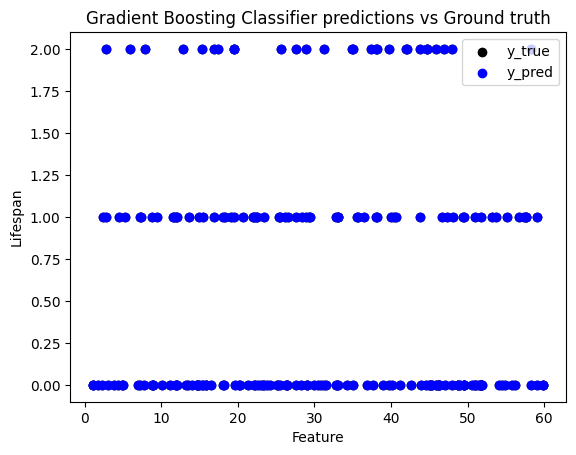

In [41]:
# Plot outputs
plt.scatter(X_test_raw[:, 4], y_test,  color='black', label='y_true')  # Observed y values
plt.scatter(X_test_raw[:, 4], y_pred_test, color='blue', label='y_pred')  # Predicted y values
plt.xlabel('Feature')
plt.ylabel('Lifespan')
plt.title(r'Gradient Boosting Classifier predictions vs Ground truth')
plt.legend()
plt.show()

### 4.2 Hyperparameter Tuning Framework for Artificial Neural Network

In [42]:
# First we can define some functions to create our model then compile and train it
# This should make our lives a bit easier and the code clearer when it comes to finding the parameters
# This is a very simple one just for varying the number of hidden units, but using loops you could make something allowing much more complexity.
alpha = 0.001
kernel_regularizer = L2(l2=alpha) #Ridge

def create_model(n_hidden):
  model = Sequential([
    Dense(8, activation=relu, input_shape=(X_train.shape[1],), kernel_regularizer=kernel_regularizer),
    #Dropout(0.2),
    Dense(12, activation=relu, kernel_regularizer=kernel_regularizer),
    #Dropout(0.2),
    Dense(n_hidden*5, activation=relu, kernel_regularizer=kernel_regularizer),

    Dense(n_hidden, activation=relu, kernel_regularizer=kernel_regularizer),

    Dense(3, activation=softmax)])

  print(model.summary())

  return model

def model_compile_and_training(model, X_train, y_train, X_valid, y_valid, learning_rate, n_epochs, batch_size):
    mymodel = model
    mymodel.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #callback = EarlyStopping(monitor='val_loss', patience=20)

    m = {}
    m[0] = np.sum((y_train == 0)) # Count how many times `0` appears in the target matrix.
    m[1] = np.sum((y_train == 1)) # Count how many times `1` appears in the target matrix.
    m[2] = np.sum((y_train == 2))
    #m[3] = np.sum((y_train == 3).astype(int))

    m_total = m[0] + m[1] + m[2]
    #m_total = m[0] + m[1] + m[2] + m[3]

    class_weight = {0: m_total / (3.0 * m[0]), 1: m_total / (3.0 * m[1]), 2: m_total / (3.0 * m[2])}
    #class_weight = {0: m_total / (4.0 * m[0]), 1: m_total / (4.0 * m[1]), 2: m_total / (4.0 * m[2]), 3: m_total / (4.0 * m[3])}

    history = mymodel.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_valid, y_valid), class_weight=class_weight) # Verbose=0 suppresses the output

    return mymodel, history

In [43]:
SEED=0
tensorflow.random.set_seed(SEED)
random.seed(SEED)

HUs = [2,6,10,15,20,30,40,50,60,70,80,90,100]
#HUs = [20,40,85,90,100]
train_array = np.full([len(HUs)], np.nan)
valid_array = np.full([len(HUs)], np.nan)
f1_train_array = np.full([len(HUs)], np.nan)
f1_valid_array = np.full([len(HUs)], np.nan)

for HU_index, HU in enumerate(HUs):
  # Run our two functions to create and compile the model
  mymodel = create_model(n_hidden=HU)
  model, history = model_compile_and_training(mymodel, X_train, y_train, X_valid, y_valid, learning_rate=0.001, n_epochs=100, batch_size=5)

  y_pred_train_sparse = model.predict(X_train)
  y_pred_train=[]
  for sparseOutput in y_pred_train_sparse:
    y_pred_train.append(np.argmax(sparseOutput))

  train_array[HU_index] = accuracy_score(y_train, y_pred_train)
  #f1_train_array[HU_index] = f1_score(y_train, y_pred_train, average='macro', pos_label=None)

  y_pred_valid_sparse = model.predict(X_valid)
  y_pred_valid=[]
  for sparseOutput in y_pred_valid_sparse:
    y_pred_valid.append(np.argmax(sparseOutput))

  valid_array[HU_index] = accuracy_score(y_valid, y_pred_valid)
  #f1_valid_array[HU_index] = f1_score(y_valid, y_pred_valid, average='macro', pos_label=None)


# Select our best performing C (biggest f1)
best_HU_index = np.argmax(valid_array)
best_HU= HUs[best_HU_index]
print('The best number of hidden units:', best_HU)
print('Accuracy with ',best_HU,' hidden units: ',valid_array[best_HU_index])

#valid_array = np.array(valid_array)
#train_array = np.array(train_array)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              22 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 341 (1.33 KB)

 Trainable params: 341 (1.33 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4095 - loss: 1.1180 - val_accuracy: 0.3600 - val_loss: 1.1141
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4184 - loss: 1.1045 - val_accuracy: 0.3600 - val_loss: 1.1059
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4184 - loss: 1.0975 - val_accuracy: 0.3600 - val_loss: 1.1016
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4071 - loss: 1.0939 - val_accuracy: 0.3600 - val_loss: 1.0995
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4337 - loss: 1.0922 - val_accuracy: 0.3600 - val_loss: 1.0986
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4372 - loss: 1.0914 - val_accuracy: 0.3600 - val_loss: 1.0982
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4707 - loss: 1.0911 - val_accuracy: 0.3600 - val_loss: 1.0981
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4555 - loss: 1.0909 - val

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 30)                  │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │             186 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 777 (3.04 KB)

 Trainable params: 777 (3.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4629 - loss: 1.1289 - val_accuracy: 0.4800 - val_loss: 1.0808
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5212 - loss: 1.1063 - val_accuracy: 0.4900 - val_loss: 1.0624
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4915 - loss: 1.0916 - val_accuracy: 0.4800 - val_loss: 1.0455
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4706 - loss: 1.0785 - val_accuracy: 0.4850 - val_loss: 1.0312
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4492 - loss: 1.0653 - val_accuracy: 0.4650 - val_loss: 1.0176
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4749 - loss: 1.0468 - val_accuracy: 0.5050 - val_loss: 0.9964
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5225 - loss: 1.0148 - val_accuracy: 0.5550 - val_loss: 0.9599
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5573 - loss: 0.9603 - val

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 50)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,373 (5.36 KB)

 Trainable params: 1,373 (5.36 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2016 - loss: 1.1394 - val_accuracy: 0.3200 - val_loss: 1.1376
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3070 - loss: 1.1165 - val_accuracy: 0.4450 - val_loss: 1.1056
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3552 - loss: 1.1019 - val_accuracy: 0.4150 - val_loss: 1.0888
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3679 - loss: 1.0836 - val_accuracy: 0.4550 - val_loss: 1.0611
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4125 - loss: 1.0504 - val_accuracy: 0.5000 - val_loss: 1.0178
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4449 - loss: 1.0048 - val_accuracy: 0.5400 - val_loss: 0.9614
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4773 - loss: 0.9570 - val_accuracy: 0.5900 - val_loss: 0.9092
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5164 - loss: 0.9172 - val

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 75)                  │             975 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 15)                  │           1,140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 3)                   │              48 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,343 (9.15 KB)

 Trainable params: 2,343 (9.15 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4282 - loss: 1.1456 - val_accuracy: 0.4900 - val_loss: 1.1147
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4887 - loss: 1.1175 - val_accuracy: 0.4800 - val_loss: 1.0977
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4930 - loss: 1.1023 - val_accuracy: 0.4950 - val_loss: 1.0804
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5046 - loss: 1.0875 - val_accuracy: 0.4900 - val_loss: 1.0559
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5180 - loss: 1.0616 - val_accuracy: 0.5050 - val_loss: 1.0223
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5663 - loss: 1.0121 - val_accuracy: 0.5950 - val_loss: 0.9575
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5905 - loss: 0.9419 - val_accuracy: 0.6000 - val_loss: 0.9118
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6367 - loss: 0.8693 - val

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 100)                 │           1,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 20)                  │           2,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 3)                   │              63 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,563 (13.92 KB)

 Trainable params: 3,563 (13.92 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3950 - loss: 1.1589 - val_accuracy: 0.5050 - val_loss: 1.1204
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4389 - loss: 1.1249 - val_accuracy: 0.4700 - val_loss: 1.1076
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4106 - loss: 1.1144 - val_accuracy: 0.4150 - val_loss: 1.1030
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4006 - loss: 1.1048 - val_accuracy: 0.3900 - val_loss: 1.0985
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3562 - loss: 1.0974 - val_accuracy: 0.3950 - val_loss: 1.0939
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3657 - loss: 1.0899 - val_accuracy: 0.3650 - val_loss: 1.0932
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3772 - loss: 1.0813 - val_accuracy: 0.3850 - val_loss: 1.0879
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3765 - loss: 1.0722 - val

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 150)                 │           1,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 30)                  │           4,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 3)                   │              93 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,753 (26.38 KB)

 Trainable params: 6,753 (26.38 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4444 - loss: 1.1715 - val_accuracy: 0.3800 - val_loss: 1.1382
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4437 - loss: 1.1322 - val_accuracy: 0.3350 - val_loss: 1.1248
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4216 - loss: 1.1200 - val_accuracy: 0.3700 - val_loss: 1.1172
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4122 - loss: 1.1129 - val_accuracy: 0.3450 - val_loss: 1.1133
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4465 - loss: 1.1064 - val_accuracy: 0.3850 - val_loss: 1.1044
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4623 - loss: 1.1003 - val_accuracy: 0.5100 - val_loss: 1.0762
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5010 - loss: 1.0876 - val_accuracy: 0.5350 - val_loss: 1.0192
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5583 - loss: 1.0470 - val

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 200)                 │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 40)                  │           8,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 3)                   │             123 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,943 (42.75 KB)

 Trainable params: 10,943 (42.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3812 - loss: 1.1790 - val_accuracy: 0.4550 - val_loss: 1.1192
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3759 - loss: 1.1207 - val_accuracy: 0.4550 - val_loss: 1.0995
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3877 - loss: 1.1025 - val_accuracy: 0.4550 - val_loss: 1.0905
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3860 - loss: 1.0927 - val_accuracy: 0.4650 - val_loss: 1.0795
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3872 - loss: 1.0842 - val_accuracy: 0.4700 - val_loss: 1.0739
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3872 - loss: 1.0818 - val_accuracy: 0.4200 - val_loss: 1.0658
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4030 - loss: 1.0709 - val_accuracy: 0.4300 - val_loss: 1.0615
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4199 - loss: 1.0602 - val

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 250)                 │           3,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 50)                  │          12,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,133 (63.02 KB)

 Trainable params: 16,133 (63.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3839 - loss: 1.1941 - val_accuracy: 0.4300 - val_loss: 1.1215
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4093 - loss: 1.1184 - val_accuracy: 0.3850 - val_loss: 1.0410
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3589 - loss: 1.0545 - val_accuracy: 0.5100 - val_loss: 0.9561
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4672 - loss: 0.9574 - val_accuracy: 0.6050 - val_loss: 0.8243
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6283 - loss: 0.8119 - val_accuracy: 0.6350 - val_loss: 0.7687
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6764 - loss: 0.7227 - val_accuracy: 0.6500 - val_loss: 0.7760
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6850 - loss: 0.6981 - val_accuracy: 0.6450 - val_loss: 0.8002
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6809 - loss: 0.6939 - val

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 300)                 │           3,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 60)                  │          18,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 3)                   │             183 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,323 (87.20 KB)

 Trainable params: 22,323 (87.20 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3754 - loss: 1.2054 - val_accuracy: 0.4200 - val_loss: 1.1417
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3473 - loss: 1.1356 - val_accuracy: 0.4000 - val_loss: 1.1169
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3838 - loss: 1.1045 - val_accuracy: 0.4100 - val_loss: 1.0712
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4273 - loss: 1.0495 - val_accuracy: 0.4550 - val_loss: 0.9895
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4688 - loss: 0.9797 - val_accuracy: 0.4700 - val_loss: 0.9383
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4958 - loss: 0.9302 - val_accuracy: 0.5100 - val_loss: 0.8892
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5621 - loss: 0.8709 - val_accuracy: 0.6550 - val_loss: 0.8223
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6079 - loss: 0.7761 - val

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 350)                 │           4,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 70)                  │          24,570 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 3)                   │             213 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,513 (115.29 KB)

 Trainable params: 29,513 (115.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4095 - loss: 1.2059 - val_accuracy: 0.4800 - val_loss: 1.0958
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4443 - loss: 1.1077 - val_accuracy: 0.4950 - val_loss: 1.0446
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4622 - loss: 1.0570 - val_accuracy: 0.5500 - val_loss: 0.9506
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5349 - loss: 0.9696 - val_accuracy: 0.5800 - val_loss: 0.8636
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6346 - loss: 0.8450 - val_accuracy: 0.6650 - val_loss: 0.8324
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6815 - loss: 0.7490 - val_accuracy: 0.6850 - val_loss: 0.7698
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7089 - loss: 0.6951 - val_accuracy: 0.7050 - val_loss: 0.7396
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7281 - loss: 0.6640 - val

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 400)                 │           5,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 80)                  │          32,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 3)                   │             243 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,703 (147.28 KB)

 Trainable params: 37,703 (147.28 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3715 - loss: 1.2169 - val_accuracy: 0.4800 - val_loss: 1.1360
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3626 - loss: 1.1284 - val_accuracy: 0.4100 - val_loss: 1.1063
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3294 - loss: 1.1046 - val_accuracy: 0.3950 - val_loss: 1.0666
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3571 - loss: 1.0662 - val_accuracy: 0.4350 - val_loss: 1.0368
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3947 - loss: 1.0277 - val_accuracy: 0.4650 - val_loss: 1.0449
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4387 - loss: 0.9912 - val_accuracy: 0.4750 - val_loss: 1.0278
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4577 - loss: 0.9648 - val_accuracy: 0.4950 - val_loss: 1.0171
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4676 - loss: 0.9343 - val

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 450)                 │           5,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 90)                  │          40,590 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 3)                   │             273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,893 (183.18 KB)

 Trainable params: 46,893 (183.18 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3703 - loss: 1.2434 - val_accuracy: 0.3000 - val_loss: 1.1534
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2709 - loss: 1.1366 - val_accuracy: 0.2850 - val_loss: 1.1372
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2834 - loss: 1.1090 - val_accuracy: 0.3150 - val_loss: 1.1373
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3131 - loss: 1.0917 - val_accuracy: 0.3400 - val_loss: 1.1235
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3551 - loss: 1.0644 - val_accuracy: 0.3900 - val_loss: 1.0948
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3506 - loss: 1.0459 - val_accuracy: 0.4100 - val_loss: 1.0689
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3893 - loss: 1.0246 - val_accuracy: 0.4550 - val_loss: 1.0287
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4345 - loss: 1.0010 - val

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 500)                 │           6,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 100)                 │          50,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 3)                   │             303 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,083 (222.98 KB)

 Trainable params: 57,083 (222.98 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3888 - loss: 1.2520 - val_accuracy: 0.4900 - val_loss: 1.1258
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4184 - loss: 1.1415 - val_accuracy: 0.4850 - val_loss: 1.1118
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4187 - loss: 1.1199 - val_accuracy: 0.5000 - val_loss: 1.0992
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4203 - loss: 1.1042 - val_accuracy: 0.4700 - val_loss: 1.0999
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4273 - loss: 1.0874 - val_accuracy: 0.4600 - val_loss: 1.0790
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4637 - loss: 1.0532 - val_accuracy: 0.5450 - val_loss: 1.0196
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4938 - loss: 0.9832 - val_accuracy: 0.6100 - val_loss: 0.8799
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6039 - loss: 0.8271 - val

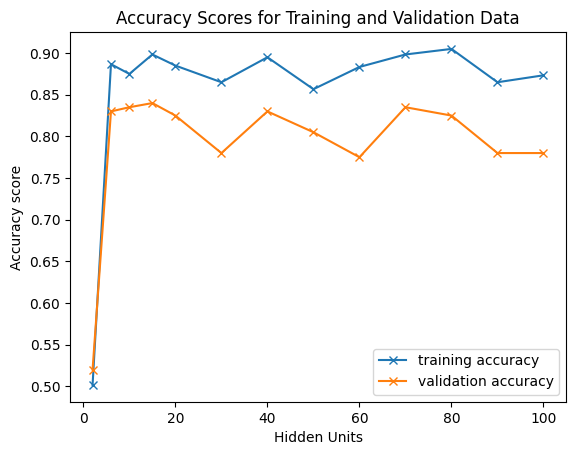

In [44]:
# plot the results
plt.figure()
plt.plot(HUs, train_array, '-x', label='training accuracy')
plt.plot(HUs, valid_array, '-x', label= 'validation accuracy')
plt.xlabel('Hidden Units')
plt.ylabel('Accuracy score')
plt.title('Accuracy Scores for Training and Validation Data')
plt.legend()

### 4.3 Evaluation for Artificial Neural Network

In [45]:
SEED=0 # 2,4,10,20,40,80,90,100
tensorflow.random.set_seed(SEED)
random.seed(SEED)

model = create_model(n_hidden=best_HU)
mymodel, history = model_compile_and_training(model, X_train, y_train, X_valid, y_valid, learning_rate= 0.001, n_epochs=100, batch_size=5)

ce_test, acc_test = mymodel.evaluate(X_test, y_test)
print('The cross entropy loss on the test data:', ce_test)
print('The accuracy on the test data:', acc_test)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_65 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 75)                  │             975 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 15)                  │           1,140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 3)                   │              48 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,343 (9.15 KB)

 Trainable params: 2,343 (9.15 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3845 - loss: 1.1475 - val_accuracy: 0.2900 - val_loss: 1.1321
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3174 - loss: 1.1151 - val_accuracy: 0.4100 - val_loss: 1.1185
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3682 - loss: 1.1044 - val_accuracy: 0.4300 - val_loss: 1.1034
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3673 - loss: 1.0918 - val_accuracy: 0.4450 - val_loss: 1.0895
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3725 - loss: 1.0805 - val_accuracy: 0.4150 - val_loss: 1.0879
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3654 - loss: 1.0704 - val_accuracy: 0.4000 - val_loss: 1.0796
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3666 - loss: 1.0624 - val_accuracy: 0.3850 - val_loss: 1.0769
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3536 - loss: 1.0535 - val

In [46]:
y_pred_test_sparse = mymodel.predict(X_test)
y_test_pred=[]
for sparseOutput in y_pred_test_sparse:
  y_test_pred.append(np.argmax(sparseOutput))

acc = accuracy_score(y_test, y_test_pred)
print('The accuracy score on the test data:', acc)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
The accuracy score on the test data: 0.865


The accuracy on the test data with the selected hyperparameter: 0.865
The F1 score on the test data with the selected hyperparameter: 0.8667449013783315
Precision on test data: 0.8705979809689417
Recall on test data: 0.865


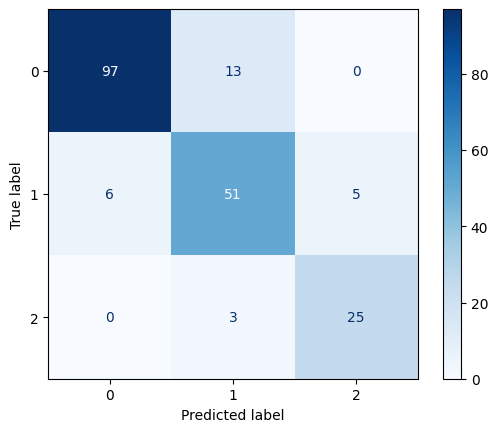

In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred))
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)

acc_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted', pos_label=1)
print('The accuracy on the test data with the selected hyperparameter:', acc_test)
print('The F1 score on the test data with the selected hyperparameter:', f1_test)
pre_test = precision_score(y_test, y_test_pred, average='weighted', pos_label=1)
print('Precision on test data:', pre_test)
reca_test = recall_score(y_test, y_test_pred, average='weighted', pos_label=1)
print('Recall on test data:', reca_test)

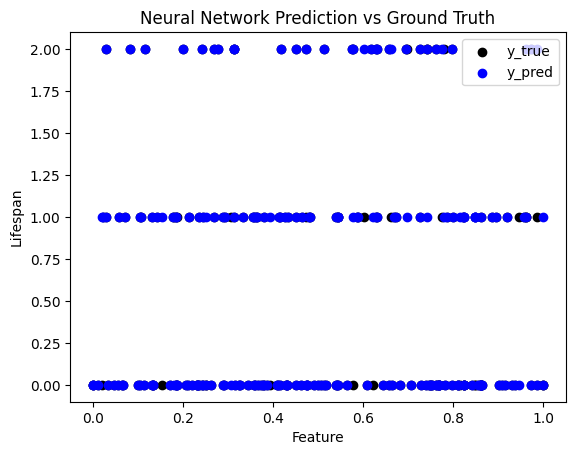

In [48]:
# Plot our predictions
plt.scatter(X_test[:,4], y_test, color='black', label='y_true') # Observed y values
plt.scatter(X_test[:,4], y_test_pred, color='blue', label='y_pred') # predicted y values
plt.xlabel('Feature')
plt.ylabel('Lifespan')
plt.title('Neural Network Prediction vs Ground Truth')
plt.legend()
plt.show()